# **Introduction**

In this notebook, we are going to train a convolutional neural network model to classify images of health cells and cells infected by the malaria parasite, following two steps: first, infected images are converted to the [LAB color space](https://en.wikipedia.org/wiki/CIELAB_color_space). By doing this, the redish blobs, present in infected cells, assume the green color. Next, we take the coordinate corresponding to the maximum pixel value in the green channel of each infected image, and a bounding box is created surrounding the pathological point. A CNN bounding box regressor is trained in order to detect and create new bounding boxes for Out-of-Sample data. We then use the trained model as feature extractor to extract features from infected and uninfected cells. Finally, using the features, we train a support vector machine to classify the images.

 &nbsp;
 


In [0]:
""" 
The data was rescaled, loaded and saved as numpy arrays in another notebook.
"""

# Load the dataset
import numpy as np

X = np.load('/content/drive/My Drive/data/data_imgs.npy')
y_true = np.load('/content/drive/My Drive/data/true.npy')

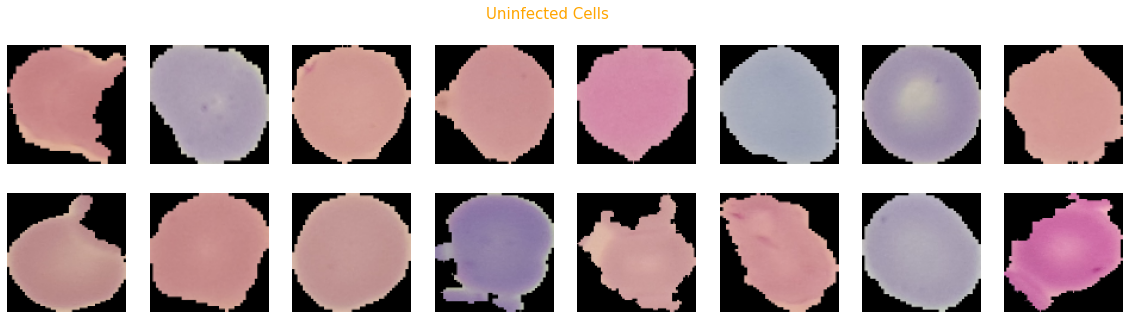

<Figure size 432x288 with 0 Axes>

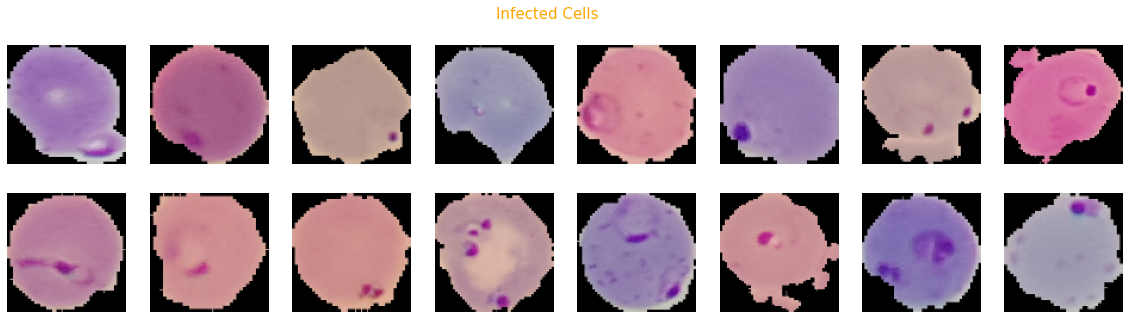

<Figure size 432x288 with 0 Axes>

In [0]:
visualize_samples(X[y_true[:, 1]==0], rows=2, cols=8, title='Uninfected Cells')
visualize_samples(X[y_true[:, 1]==1], rows=2, cols=8, title='Infected Cells')

&nbsp;

In [0]:
# Importing required packages

import cv2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from visualization import *

### Converting infected cells images to the LAB color space.

In [0]:
from skimage.feature import peak_local_max

# load infected cells
infected = X[y_true[:, 1]==1]

# convert the images to the Lab color space
images_lab = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2LAB) for image in infected])

# Peak local maximum in the green channel
local_peaks = np.array([peak_local_max(image[..., 1], num_peaks=1).flatten() for image in images_lab])

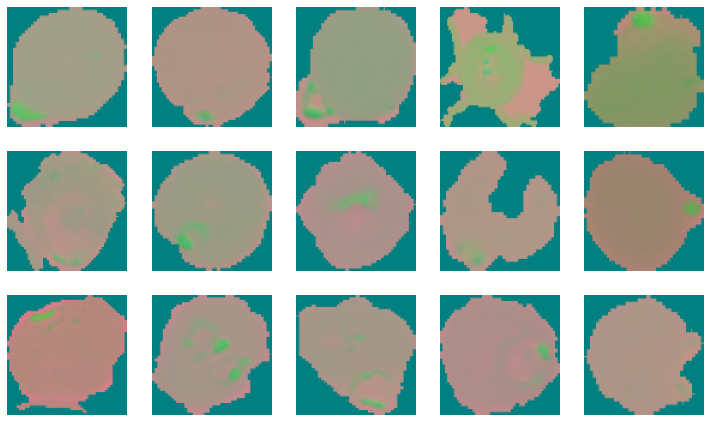

<Figure size 432x288 with 0 Axes>

In [0]:
visualize_samples(images_lab, cols=5, rows=3)

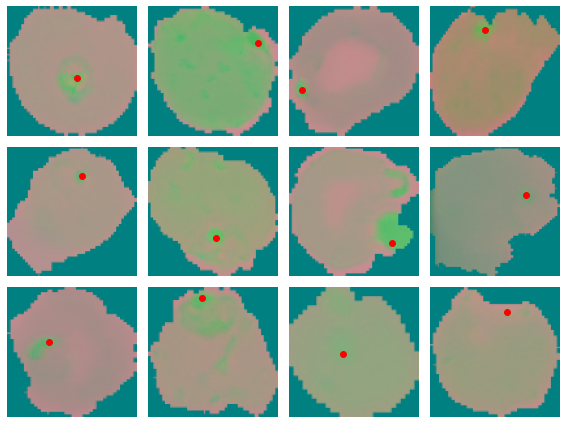

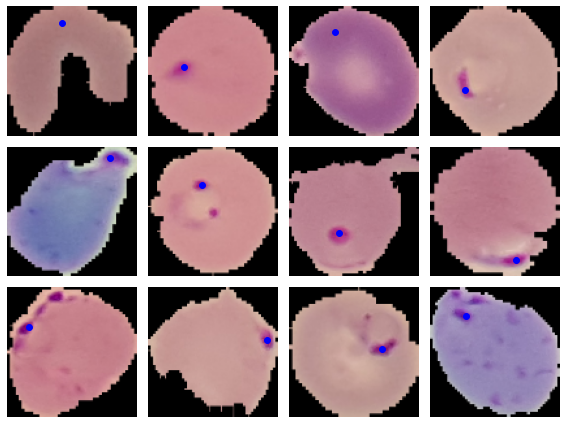

In [0]:
visualize_peaks(images_lab, local_peaks, rows=3, cols=4)
visualize_peaks(infected, local_peaks, rows=3, cols=4, color='b')

In [0]:
def generate_bbox(points):
  bboxes = []
  for box_id, point in enumerate(points):
    min_row = point[0] - 18
    min_col = point[1] - 18
    max_row = point[0] + 18
    max_col = point[1] + 18
    bboxes.append([box_id, min_row, min_col, max_row, max_col])
  return np.array(bboxes)
bboxes = generate_bbox(local_peaks)

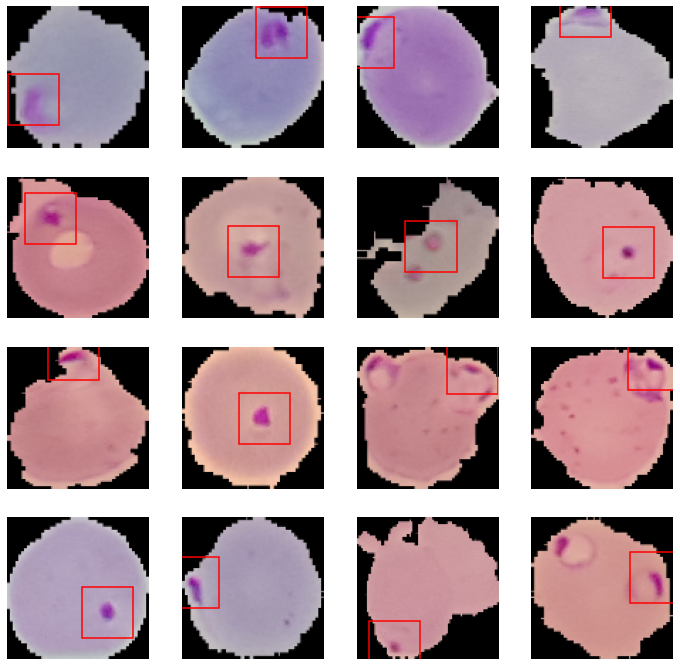

In [0]:
visualize_bboxes(infected, original_bboxes=bboxes, cols=4, rows=4)

\

### Model definition 


In [0]:
scaler = MinMaxScaler()
X_infected = infected.astype(np.float32) / 255
y_bboxes_norm = scaler.fit_transform(bboxes[:, 1:]).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X_infected, y_bboxes_norm, test_size=.2, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=1)

In [0]:
IMAGE_SHAPE = X.shape[1:]

x = inputs = Input(IMAGE_SHAPE)

x = Conv2D(32, (5, 5), activation='relu', name='conv_1')(x)
x = MaxPooling2D(name='pool1')(x)

x = Conv2D(64, (3, 3), activation='relu', name='conv_2')(x)
x = MaxPooling2D(name='pool2')(x)

x = SeparableConv2D(128, (3, 3), activation='relu', name='sepconv_1')(x)
x = MaxPooling2D(name='pool3')(x)

x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(250, activation='relu', name='fc2')(x)
x = Dropout(0.25)(x)

outputs = Dense(4, activation='linear', name='output')(x)

model = Model(inputs, outputs)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 46, 46, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 23, 23, 64)        0         
_________________________________________________________________
sepconv_1 (SeparableConv2D)  (None, 21, 21, 128)       8896      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 10, 10, 128)       0  

Epoch 1/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0582 - mae: 0.1934 - val_loss: 0.0212 - val_mae: 0.1084
Epoch 2/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0193 - mae: 0.1010 - val_loss: 0.0137 - val_mae: 0.0761
Epoch 3/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0150 - mae: 0.0861 - val_loss: 0.0121 - val_mae: 0.0713
Epoch 4/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0134 - mae: 0.0799 - val_loss: 0.0112 - val_mae: 0.0646
Epoch 5/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0125 - mae: 0.0758 - val_loss: 0.0105 - val_mae: 0.0580
Epoch 6/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0116 - mae: 0.0727 - val_loss: 0.0102 - val_mae: 0.0588
Epoch 7/15
328/328 [==============================] - 4s 12ms/step - loss: 0.0113 - mae: 0.0710 - val_loss: 0.0103 - val_mae: 0.0586
Epoch 8/15
328/328 [==============================] - 4s 12ms/step - 

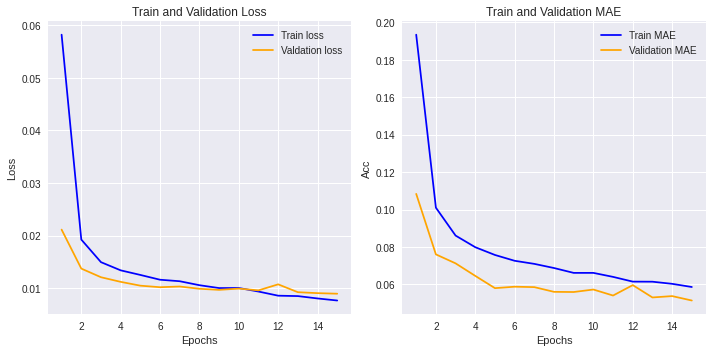

In [0]:
model.compile(loss='mse',
              optimizer=Adam(lr=0.001),
              metrics=['mae'])

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                    epochs=15)

visualize_results(history)

In [0]:
pred_bboxes = model.predict(X_test)

pred_bboxes = scaler.inverse_transform(pred_bboxes).astype(np.int32)
test_bboxes = scaler.inverse_transform(y_test).astype(np.int32)

In [0]:
box_id = np.arange(len(pred_bboxes)).reshape(-1, 1)

pred_bboxes = np.hstack([box_id, pred_bboxes])
test_bboxes = np.hstack([box_id, test_bboxes])

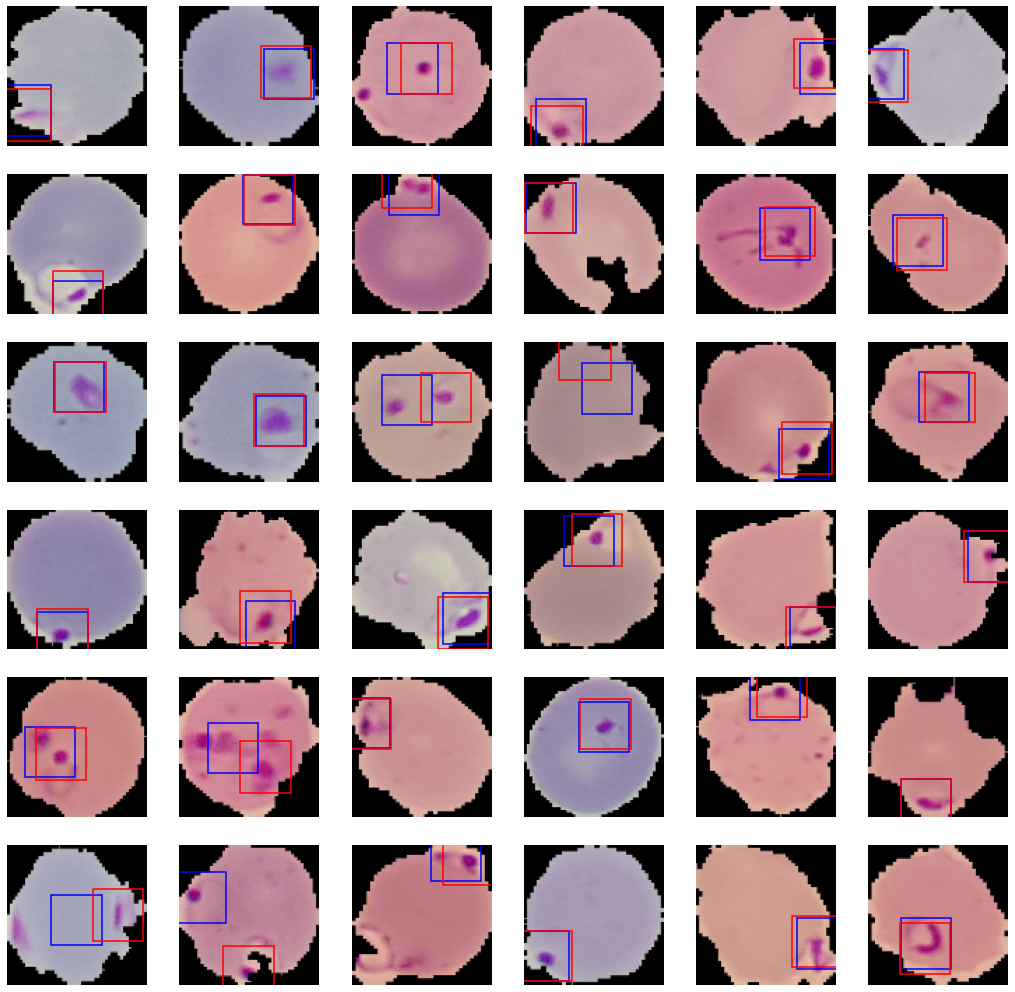

In [0]:
# BLUE BOXES = PREDICTED 
# RED BOXES = ORIGINAL

visualize_bboxes(X_test, 
                 original_bboxes=test_bboxes, 
                 pred_bboxes=pred_bboxes,
                 cols=6,
                 rows=6)

&nbsp;

## Feature Extraction and Classification

In [0]:
outputs = model.get_layer("fc1").output
feature_extractor = Model(model.input, outputs)
feature_extractor.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 96, 96, 32)        2432      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 48, 48, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 46, 46, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 23, 23, 64)        0         
_________________________________________________________________
sepconv_1 (SeparableConv2D)  (None, 21, 21, 128)       8896      
_________________________________________________________________
pool3 (MaxPooling2D)         (None, 10, 10, 128)       0  

In [0]:
label_1 = np.ones((len(X[y_true[:, 1]==1]), 1))
label_0 = np.zeros((len(X[y_true[:, 1]==0]), 1))

y_label = np.vstack([label_1, label_0])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=.2, random_state=1)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [0]:
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

Now we train a SVM with the features extracted from the images

In [0]:
SVM_model = make_pipeline(StandardScaler(),
                          SVC(kernel='rbf', C=3.5))

SVM_model.fit(train_features, y_train.ravel())
SVM_yhat = SVM_model.predict(test_features)

&nbsp;

## Model Evaluation

In [0]:
report = classification_report(y_test, SVM_yhat, target_names=['Infected', 'Uninfected'])
print("\t\t\tSVM Classification Report\n")
print(report)

			SVM Classification Report

              precision    recall  f1-score   support

    Infected       0.94      0.97      0.96      2665
  Uninfected       0.97      0.94      0.96      2847

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



<Figure size 576x396 with 0 Axes>

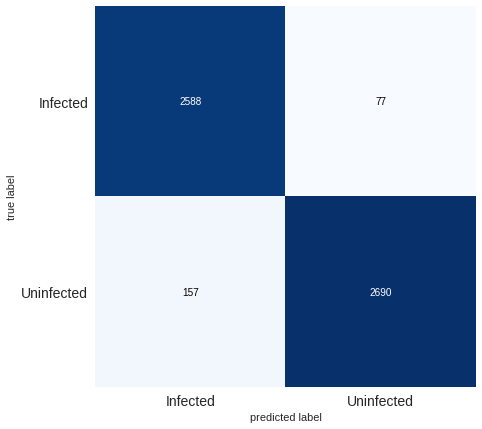

In [0]:
cm  = confusion_matrix(y_test, SVM_yhat)
plt.figure()
plot_confusion_matrix(cm,figsize=(7, 7), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Infected', 'Uninfected'], fontsize=14)
plt.yticks(range(2), ['Infected', 'Uninfected'], fontsize=14)
plt.show()